<a href="https://colab.research.google.com/github/KarthiK2601/ViT/blob/main/MNIST_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Prepare the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_chans, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, H, W)
        return x.flatten(2).transpose(1, 2)  # (B, N, E)

class ViT(nn.Module):
    def __init__(self, patch_size, in_chans, embed_dim, num_heads, num_layers, num_classes):
        super(ViT, self).__init__()
        self.embedding = PatchEmbedding(patch_size, in_chans, embed_dim)

        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

# Define the model, loss function and optimizer
model = ViT(patch_size=7, in_chans=1, embed_dim=64, num_heads=8, num_layers=3, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
epochs = 10
for epoch in range(epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')



100%|██████████| 9912422/9912422 [00:00<00:00, 105528002.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11691506.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25533556.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3254275.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss: 0.4714979827404022
Epoch 2/10, Loss: 0.1976701319217682
Epoch 3/10, Loss: 0.1200089380145073
Epoch 4/10, Loss: 0.09421132504940033
Epoch 5/10, Loss: 0.1198849231004715
Epoch 6/10, Loss: 0.2505444884300232
Epoch 7/10, Loss: 0.06324730813503265
Epoch 8/10, Loss: 0.012896470725536346
Epoch 9/10, Loss: 0.09757256507873535
Epoch 10/10, Loss: 0.006099083460867405
Accuracy of the network on the 10000 test images: 97.88%


In [3]:
import torchvision


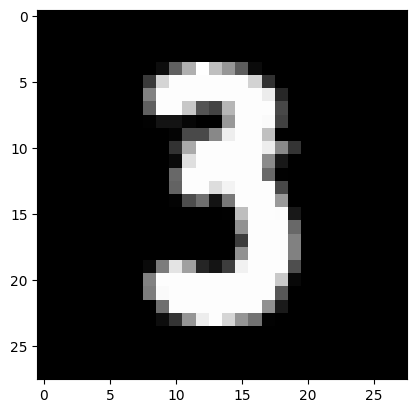

Predicted: 8, Actual: 3


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Choose a random image from the test set
images, labels = next(iter(testloader))
random_index = np.random.randint(len(images))
random_image = images[random_index].unsqueeze(0)

# Display the image
imshow(torchvision.utils.make_grid(images[random_index]))

# Make a prediction
model.eval()
with torch.no_grad():
    output = model(random_image)
    _, predicted = torch.max(output.data, 1)

print(f'Predicted: {predicted.item()}, Actual: {labels[random_index]}')
